# Are novice/expert subjects more similar to themselves or others?


In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

import seaborn as sns

sns.set(color_codes=True, style="white", context="talk", font_scale=1)
PALETTE = sns.color_palette("Set1")

from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
from hyppo.independence import Dcorr
from scipy.stats import multiscale_graphcorr
from hyppo.ksample._utils import k_sample_transform
from graspy.plot import heatmap, pairplot

import sys

sys.path.append("../")
from src.tools.utils import get_files, get_latents

%load_ext autoreload
%autoreload 2
%load_ext nb_black

/home/rflperry/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


<IPython.core.display.Javascript object>

In [2]:
## Define paths, get raw
# base_dir = Path("/mnt/ssd3/ronan/data/gcca_05-26-10:39_min_rank-ZG3/")
base_dir = Path("/mnt/ssd3/ronan/data/gcca_05-26-10:39_min_rank-ZG3/")
groups, labels, subjs = get_latents(base_dir, flag="_gcca", ids=True)

<IPython.core.display.Javascript object>

In [4]:
y = np.repeat(labels, [len(g) for g in groups], axis=0)
label_transform = {
    "e": "Expert",
    "n": "Novice",
    "compassion": "Compasson",
    "restingstate": "Resting",
    "openmonitoring": "Open",
}
y_labels = [[a, b] for a, b in y]

<IPython.core.display.Javascript object>

In [62]:
def disc_stat(dist_mat, labels1, labels2=None):
    if labels2 is None:  # Reduces to normal discrim
        labels2 = np.ones(len(labels1))
    dist_mat = np.asarray(dist_mat)
    N = dist_mat.shape[0]
    stats = []

    ## For each label in the first set (i.e. subject)
    for label in np.unique(labels1):
        idxs_in = np.where(labels1 == label)[0]
        stat = []
        for i in idxs_in:  ## For each row in the in idxs
            ## Comparison made in second label category (i.e. resting)
            idxs_out = np.where(labels2 == labels2[i])[0]
            idxs_out = np.asarray(list(set(idxs_out) - set(idxs_in)))
            stat.append(
                [
                    1
                    - (
                        np.sum(dist_mat[i, j] < dist_mat[i, idxs_out])
                        + 0.5 * np.sum(dist_mat[i, j] == dist_mat[i, idxs_out])
                    )
                    / len(idxs_out)
                    for j in idxs_in
                    if i != j
                ]
            )
        ## Average percent of the time in group is larger than out group
        stats.append(np.mean(stat))

    # Equally weights each unique label
    return np.mean(stats)


##### ONE SIDED (lower) #####
def disc_pval(dist_mat, labels1, labels2=None, n_permutations=100):
    labels1 = np.asarray(labels1)
    if labels2 is None:
        labels2 = np.ones(len(labels1))
    else:
        labels2 = np.asarray(labels2)
    idxs = np.arange(len(labels1))
    obs_stat = disc_stat(dist_mat, labels1, labels2)
    null_stats = []
    for _ in range(n_permutations):
        np.random.shuffle(idxs)
        null_stat = disc_stat(dist_mat, labels1[idxs], labels2[idxs])
        null_stats.append(null_stat)

    pval = (np.sum(np.asarray(null_stats) <= obs_stat) + 1) / (n_permutations + 1)
    null_std = np.std(null_stats)

    return obs_stat, pval, null_std

<IPython.core.display.Javascript object>

In [46]:
test = [
    [0, 0, 1, 1, 1, 1],
    [0, 0, 1, 1, 1, 1],
    [1, 1, 0, 0, 1, 1],
    [1, 1, 0, 0, 1, 1],
    [1, 1, 1, 1, 0, 0],
    [1, 1, 1, 1, 0, 0],
]
disc_stat(test, [0, 0, 1, 1, 2, 2,])

0.0

<IPython.core.display.Javascript object>

In [51]:
stat_list = {}

<IPython.core.display.Javascript object>

## Discrim: expert subjects scans more similar than across state scans

In [23]:
labels

[['e', 'restingstate'],
 ['e', 'openmonitoring'],
 ['e', 'compassion'],
 ['n', 'restingstate'],
 ['n', 'openmonitoring'],
 ['n', 'compassion']]

<IPython.core.display.Javascript object>

In [64]:
ways = [[0], [1], [2]]
X, Y = k_sample_transform([np.asarray(groups[i]) for i in [0, 1, 2]], ways=ways)
X = X[:, :, :3].reshape(X.shape[0], -1)
X_dists = pairwise_distances(X, metric="euclidean")

<IPython.core.display.Javascript object>

In [65]:
state_labels = [np.where(y == 1)[0][0] for y in Y]

<IPython.core.display.Javascript object>

In [66]:
subj_labels = np.concatenate([subjs[i] for i in [0, 1, 2]])

<IPython.core.display.Javascript object>

In [67]:
obs_stat, pval, null_std = disc_pval(
    X_dists, subj_labels, state_labels, n_permutations=1000
)
stat_list["experts_all"] = (obs_stat, pval, null_std)
print(obs_stat, pval, null_std)

0.05582922824302134 0.000999000999000999 0.017891074144696185


<IPython.core.display.Javascript object>

## Discrim: novices subjects scans more similar than across state scans

In [55]:
group_idxs = [3, 4, 5]

<IPython.core.display.Javascript object>

In [56]:
ways = [[0], [1], [2]]
X, Y = k_sample_transform([np.asarray(groups[i]) for i in group_idxs], ways=ways)
X = X[:, :, :3].reshape(X.shape[0], -1)
X_dists = pairwise_distances(X, metric="euclidean")

<IPython.core.display.Javascript object>

In [57]:
state_labels = [np.where(y == 1)[0][0] for y in Y]
subj_labels = np.concatenate([subjs[i] for i in group_idxs])

<IPython.core.display.Javascript object>

In [63]:
obs_stat, pval, null_std = disc_pval(
    X_dists, subj_labels, state_labels, n_permutations=1000
)
stat_list["novices_all"] = (obs_stat, pval, null_std)
print(obs_stat, pval, null_std)

0.0557354301572618 0.000999000999000999 0.013289171495564394


<IPython.core.display.Javascript object>

## Canonical Correlations

In [7]:
groups[0][0].shape

(18715, 3)

<IPython.core.display.Javascript object>

In [9]:
ways = [[0], [1], [2], [3], [4], [5]]
X, Y = k_sample_transform(groups, ways=ways)
X = X[:, :, 0].reshape(X.shape[0], -1)

<IPython.core.display.Javascript object>

In [10]:
X.shape

(228, 18715)

<IPython.core.display.Javascript object>

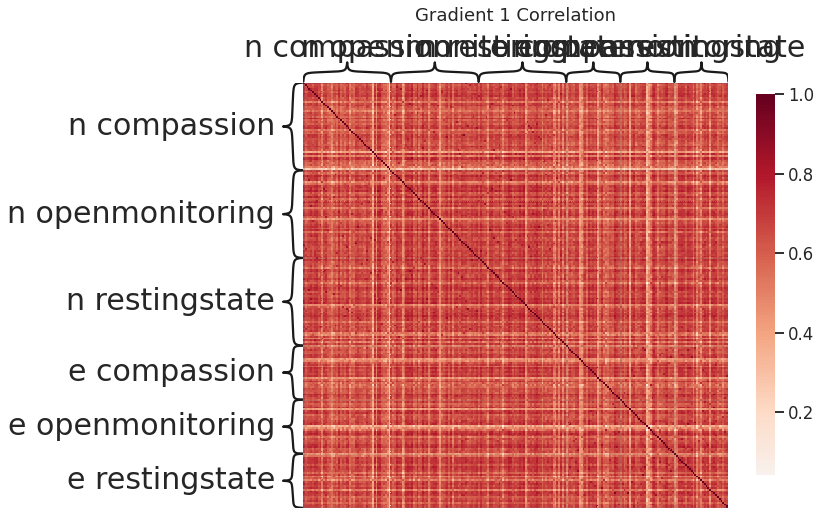

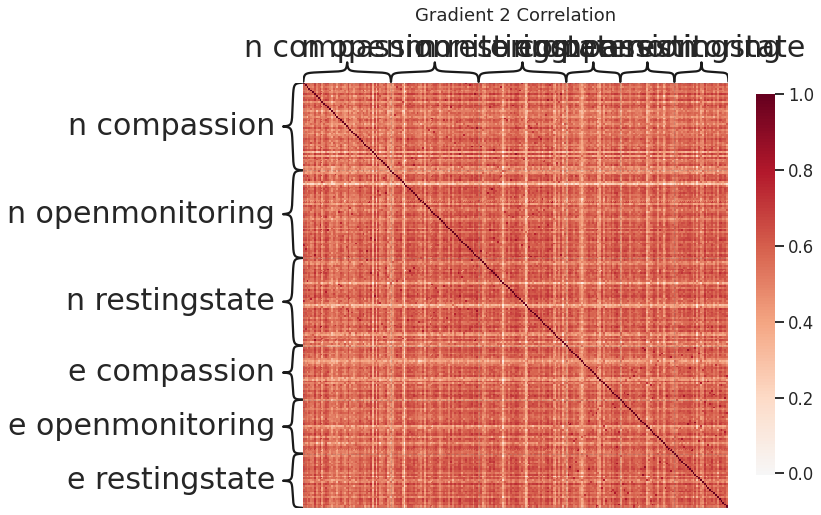

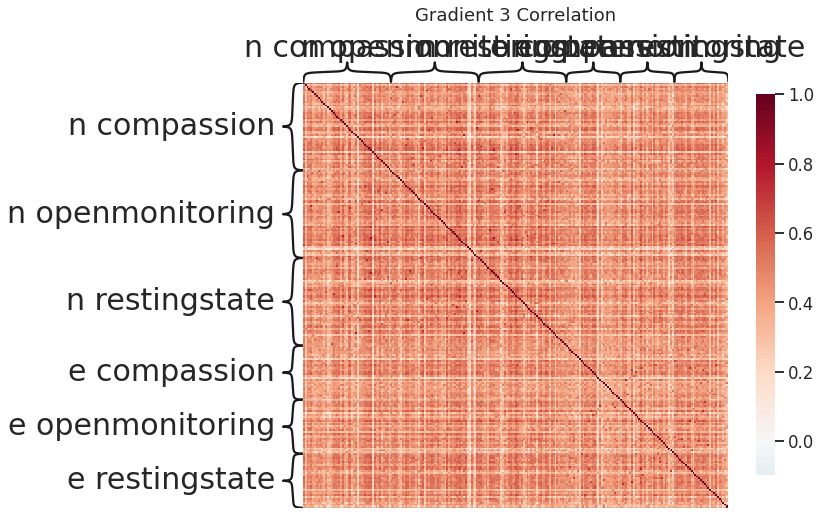

<IPython.core.display.Javascript object>

In [18]:
for i in range(3):
    ways = [[0], [1], [2], [3], [4], [5]]
    X, Y = k_sample_transform(groups, ways=ways)
    X = X[:, :, i].reshape(X.shape[0], -1)
    heatmap(
        np.corrcoef(X),
        inner_hier_labels=[a + " " + b for a, b in y_labels],
        title=f"Gradient {i+1} Correlation",
    )

## Correlation Comparison

In [10]:
## Define paths, get raw
base_dir3 = Path("/mnt/ssd3/ronan/data/gcca_05-26-10:39_min_rank-ZG3/")
base_dir2 = Path("/mnt/ssd3/ronan/data/gcca_05-17-18:27_max_rank-ZG2/")
groups3, labels3, subjs3 = get_latents(base_dir3, flag="_gcca", ids=True)
groups2, labels2, subjs2 = get_latents(base_dir2, flag="_gcca", ids=True)

<IPython.core.display.Javascript object>

In [11]:
X2 = np.concatenate([np.asarray(g) for g in groups2])
X3 = np.concatenate([np.asarray(g) for g in groups3])

<IPython.core.display.Javascript object>

In [17]:
np.all(np.concatenate(subjs2) == np.concatenate(subjs3)) and np.all(
    np.concatenate(labels2) == np.concatenate(labels3)
)

True

<IPython.core.display.Javascript object>

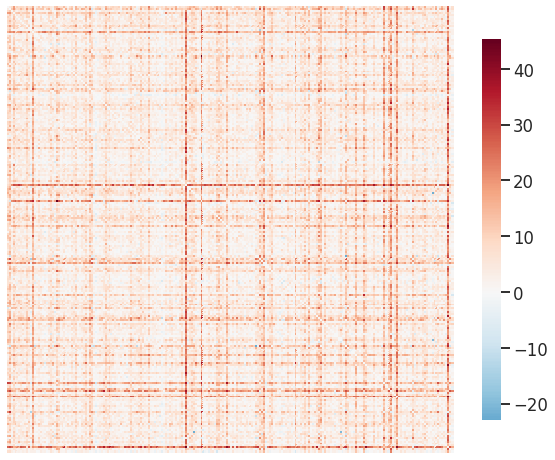

<IPython.core.display.Javascript object>

In [19]:
heatmap(pairwise_distances(X2[:, :, 0]) - pairwise_distances(X3[:, :, 0]))

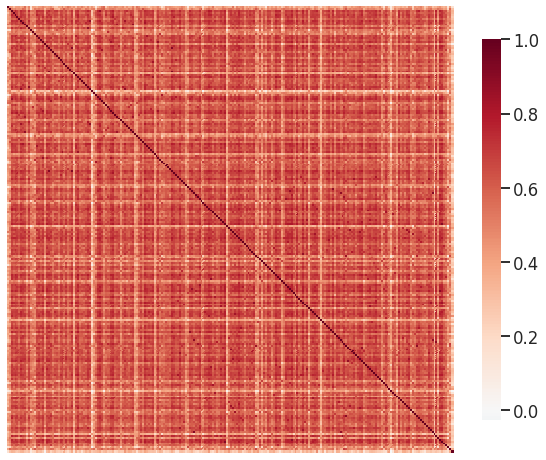

<IPython.core.display.Javascript object>

In [22]:
heatmap(np.corrcoef(X2[:, :, 0]))

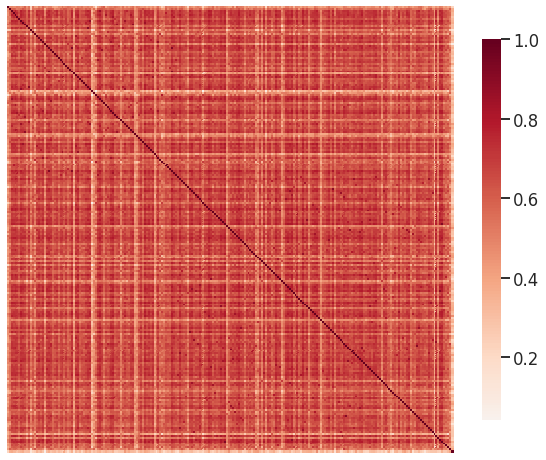

<IPython.core.display.Javascript object>

In [23]:
heatmap(np.corrcoef(X3[:, :, 0]))

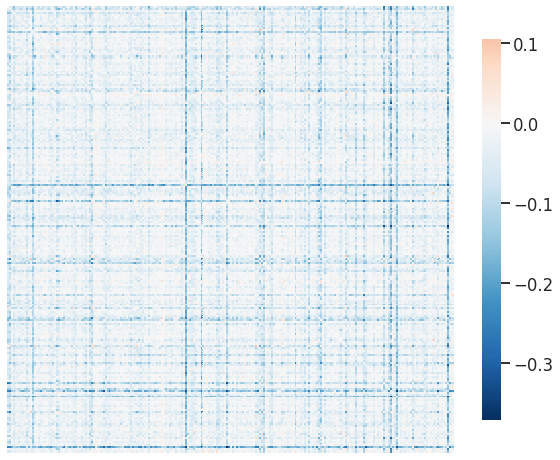

<IPython.core.display.Javascript object>

In [24]:
heatmap(np.corrcoef(X2[:, :, 0]) - np.corrcoef(X3[:, :, 0]))

### Back to original

No handles with labels found to put in legend.


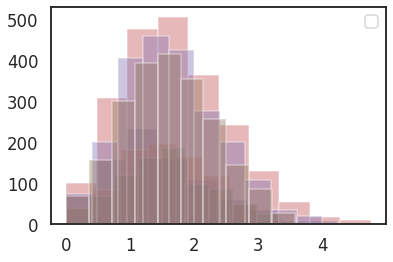

<IPython.core.display.Javascript object>

In [36]:
for label, group in zip(labels, groups):
    plt.hist(
        pairwise_distances(np.asarray(group)[:, 0]).flatten(), alpha=0.4
    )  # , label=label)
plt.legend()
plt.show()

In [37]:
for label, group in zip(labels, groups):
    print(label)
    print(f"mean {np.asarray(group)[:, 0].mean()}")
    print(f"std {np.asarray(group)[:, 0].std()}")

['e', 'restingstate']
mean -0.003764509304405062
std 1.2531954979513849
['e', 'openmonitoring']
mean -0.008851869952672573
std 1.2500013859134333
['e', 'compassion']
mean -0.024345901981171716
std 1.3597147070328905
['n', 'restingstate']
mean 0.07746043593098743
std 1.306138554360126
['n', 'openmonitoring']
mean 0.050759672614191884
std 1.244368423297943
['n', 'compassion']
mean -0.0843876795558606
std 1.2554436536096358


<IPython.core.display.Javascript object>

In [38]:
for label, group in zip(labels, groups):
    print(label)
    print(f"mean {pairwise_distances(np.asarray(group)[:, 0]).mean()}")
    print(f"std {pairwise_distances(np.asarray(group)[:, 0]).std()}")

['e', 'restingstate']
mean 1.4405756828774812
std 0.8018463586048953
['e', 'openmonitoring']
mean 1.5511026329680877
std 0.6976158570091143
['e', 'compassion']
mean 1.5720552152115748
std 0.735255181275374
['n', 'restingstate']
mean 1.6993116713206924
std 0.8308534220213261
['n', 'openmonitoring']
mean 1.6291979114795596
std 0.7528700620625483
['n', 'compassion']
mean 1.6056562252853952
std 0.7131572650266128


<IPython.core.display.Javascript object>